In [ ]:
!pip install datasets
# !pip install opendatasets
# !pip install Unidecode

In [1]:
import pandas as pd
import numpy as np
import string, os 
import platform
# from unidecode import unidecode
import re

# load dataset
# from datasets import load_dataset
# import opendatasets as od

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Dropout, GRU, Lambda
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



# set seeds for reproducability
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

# warning
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

print('Python version:', platform.python_version())
print('Tensorflow version:', tensorflow.__version__)
print('Keras version:', tensorflow.keras.__version__)

Python version: 3.7.13
Tensorflow version: 2.8.2
Keras version: 2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data

/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data


In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Load Dataset

In [ ]:
ori_news = load_dataset("ag_news", split = "train")
# ori_news = ori_news.remove_columns(['label'])

# convert to pandas
dataframe_news = pd.DataFrame(ori_news)


Using custom data configuration default


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


In [ ]:
dataframe_news_sport = dataframe_news.loc[dataframe_news['label'] == 1]
dataframe_news_tech = dataframe_news.loc[dataframe_news['label'] == 3]

print("Sport news data points length: ", len(dataframe_news_sport))
print("Technology news data points length: ", len(dataframe_news_sport))

Sport news data points length:  30000
Technology news data points length:  30000


In [ ]:
sport_texts_list = dataframe_news_sport.loc[:,'text']
sport_texts_array = sport_texts_list.values

tech_texts_list = dataframe_news_tech.loc[:,'text']
tech_texts_array = tech_texts_list.values

In [ ]:
tech_texts_array[3]

'Companies Approve New High-Capacity Disc Format (Reuters) Reuters - A group of consumer electronics\\makers said on Wednesday they approved the format for a new\\generation of discs that can store five times the data of DVDs\\at the same cost -- enough to put a full season of "The\\Sopranos" on one disc.'

In [ ]:
# texts_list = ori_news['text']
# texts_array = np.asarray(texts_list)

In [ ]:
# delete any url links in the tweet
def remove_link(text:str):
  return re.sub(r'(?:\s)http[^, ]*', '', text, flags=re.MULTILINE)

# remove line breaks
# def remove_newlines(text: str):
#   return re.sub('\n',  ' ', text) 

# remove certain words
def remove_word(text: str):
  return re.sub('reuters',  '', text) 

# only include string
def remove_special_characters(text: str):
  return re.sub(r'[^a-zA-Z\s]+', ' ', text, re.I | re.A)

# remove white space
def remove_whitespace(text: str):
  return " ".join(re.split("\s+", text, flags=re.UNICODE))

def clean_text(texts_list):
  texts_list[:] = [remove_link(text) for text in texts_list]
  # texts_list[:] = [remove_newlines(text) for text in texts_list]
  texts_list[:] = [remove_special_characters(text) for text in texts_list]
  texts_list[:] = [text.lower() for text in texts_list]
  texts_list[:] = [remove_word(text) for text in texts_list]
  texts_list[:] = [remove_whitespace(text) for text in texts_list]


clean_text(tech_texts_array)
tech_texts_array[3]

'companies approve new high capacity disc format a group of consumer electronics makers said on wednesday they approved the format for a new generation of discs that can store five times the data of dvds at the same cost enough to put a full season of the sopranos on one disc '

### Lemmatization

In [ ]:
import nltk
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','entity','ner'])
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [ ]:
import time

def lemmatize(text: str):
  return nlp(text)  

start_time = time.time()

# texts_list_lemmatized = [lemmatize(text) for text in texts_list]
texts_list_lemmatized = nlp.pipe(tech_texts_array, batch_size=32, n_process=3, disable=["parser", "entity", "ner"])

print("--- %s seconds ---" % (time.time() - start_time))

--- 5.602836608886719e-05 seconds ---


In [ ]:
def join_words(words):
  return ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in words])

start_time = time.time()

# docs1 = list(docs)[:2]
    
# result = [join_words(doc) for doc in docs1]
corpus = [join_words(text) for text in texts_list_lemmatized]
print(corpus[3])

print("--- %s seconds ---" % (time.time() - start_time))

company approve new high capacity disc format a group of consumer electronic maker say on wednesday they approve the format for a new generation of disc that can store five time the datum of dvds at the same cost enough to put a full season of the soprano on one disc
--- 30.023510694503784 seconds ---


In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data/clean_text_tech_news.txt', 'w') as writefile:
  for element in corpus:
    writefile.write(element + ",")
  writefile.close()

## Pre-processed Text

In [5]:
# Load clean text to avoid running above codes

my_file = open("/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data/clean_text_tech_news.txt", "r")
content = my_file.read()

corpus = content.split(",")
my_file.close()

In [ ]:
corpus[1]

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

corpus = word_tokenize(content)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
small_corpus = corpus[1:6000]

### Generating Sequence of N-gram Tokens

In [7]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(small_corpus):
    ## tokenization
    tokenizer.fit_on_texts(small_corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in small_corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(small_corpus)
inp_sequences[:10]

[[140, 2],
 [140, 2, 818],
 [140, 2, 818, 14],
 [140, 2, 818, 14, 90],
 [140, 2, 818, 14, 90, 314],
 [140, 2, 818, 14, 90, 314, 107],
 [140, 2, 818, 14, 90, 314, 107, 1337],
 [140, 2, 818, 14, 90, 314, 107, 1337, 3],
 [140, 2, 818, 14, 90, 314, 107, 1337, 3, 140],
 [140, 2, 818, 14, 90, 314, 107, 1337, 3, 140, 4]]

In [8]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

## Model Training

In [ ]:
# import tensorflow
# from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, GRU, Lambda
# from tensorflow import keras as k

In [ ]:
# def model_bilstm_lstm(max_sequence_len, total_words):
#     input_len = max_sequence_len - 1
#     output_dim = 100
#     model = Sequential()
    
#     # Add Input Embedding Layer
#     model.add(Embedding(total_words, output_dim , input_length=input_len))
    
#     # Add bidirectional LSTM
#     model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.05, recurrent_dropout=0.05), merge_mode = 'concat'))

#     # Add LSTM
#     model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
    
#     # Add Output Layer
#     model.add(TimeDistributed(Dense(total_words, activation='softmax')))

#     #Optimiser 
#     adam = k.optimizers.Adam(lr=0.0005, beta_1=0.001, beta_2=0.009)

#     model.compile(loss='categorical_crossentropy', optimizer='adam')
#     model.summary()

#     return model

# model = model_bilstm_lstm(max_sequence_len, total_words)

In [9]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 100, input_length=input_len))
    
    # Add Hidden Layer 1 - Bidirectional LSTM Layer
    model.add(Bidirectional(GRU(100, return_sequences=True)))
    model.add(Dropout(0.1))

    # Add Hidden Layer 2 - LSTM Layer
    model.add(GRU(100))
    model.add(Dropout(0.2))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    adam = Adam(learning_rate=0.01,beta_1=0.001, beta_2=0.009)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 174, 100)          1216300   
                                                                 
 bidirectional (Bidirectiona  (None, 174, 200)         121200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 174, 200)          0         
                                                                 
 gru_1 (GRU)                 (None, 100)               90600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12163)             1228463   
                                                        

In [10]:
from tensorflow.keras import callbacks
model_checkpoint =callbacks.ModelCheckpoint("LSTM_model_checkpoint.h5", save_best_only=True)
early_stopping = callbacks.EarlyStopping(patience=50)

In [11]:
history = model.fit(
    predictors, 
    label, 
    epochs=200, 
    batch_size=256, callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
878/878 [==============================] - 59s 62ms/step - loss: 7.2291 - accuracy: 0.0439
Epoch 2/200
878/878 [==============================] - 54s 62ms/step - loss: 6.7205 - accuracy: 0.0764
Epoch 3/200
878/878 [==============================] - 55s 62ms/step - loss: 6.2500 - accuracy: 0.1131
Epoch 4/200
878/878 [==============================] - 54s 62ms/step - loss: 5.9045 - accuracy: 0.1368
Epoch 5/200
878/878 [==============================] - 55s 62ms/step - loss: 5.6384 - accuracy: 0.1548
Epoch 6/200
878/878 [==============================] - 54s 62ms/step - loss: 5.4136 - accuracy: 0.1692
Epoch 7/200
878/878 [==============================] - 55s 62ms/step - loss: 5.2052 - accuracy: 0.1843
Epoch 8/200
878/878 [==============================] - 54s 62ms/step - loss: 5.0224 - accuracy: 0.1964
Epoch 9/200
878/878 [==============================] - 55s 62ms/step - loss: 4.8565 - accuracy: 0.2090
Epoch 10/200
878/878 [==============================] - 54s 62ms/step - l

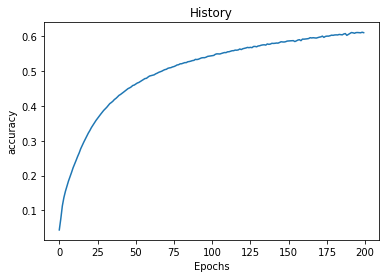

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title("History")
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.show()

In [13]:
# save the model to file
model.save('model_goethe_generator.h5')
# save the tokenizer
import pickle
pickle.dump(tokenizer, open('tokenizer_goethe.pkl', 'wb'))

### Generate Text

In [24]:
seed_text = "Television multimedia"
next_words = 100


for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # predict_x = model.predict(token_list)
  predict_x = np.argmax(model.predict(token_list, verbose=0), axis=-1)

  output_word = ""

  for word, index in tokenizer.word_index.items():
    if index == predict_x:
      output_word = word
      break

  seed_text += " " + output_word

print(seed_text)



Television multimedia friendly drive in the second quarter of wireless industry m and revenue increase as the second quarter of and gain percent compare to percent but also use to each people be to get it to use up to expect power from canada before you announce that they have to sell the e mail give a per cent over percent until the second half of accord to new research firm from forrester research inc find the first full time of the emerge market for those because they s lower level over human pressure accord to a report release thursday by lt


In [ ]:
trigrams = [([corpus[i], corpus[i + 1]], corpus[i + 2])
            for i in range(len(corpus) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['bear', 'claw'], 'back'), (['claw', 'back'], 'into'), (['back', 'into'], 'the')]


In [ ]:
vocab = set(corpus)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [ ]:
import torch

inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [ ]:
n_epochs = 300
print_every = 100
plot_every = 10
hidden_size = 10
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

RuntimeError: ignored

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)